In [95]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import multiprocessing as mp
from scipy.signal import *
import time

In [5]:
pic1 = cv2.imread("pic1.jpg",0)
pic2 = cv2.imread("pic2.jpg",0)
pic3 = cv2.imread("pic3.jpg",0)

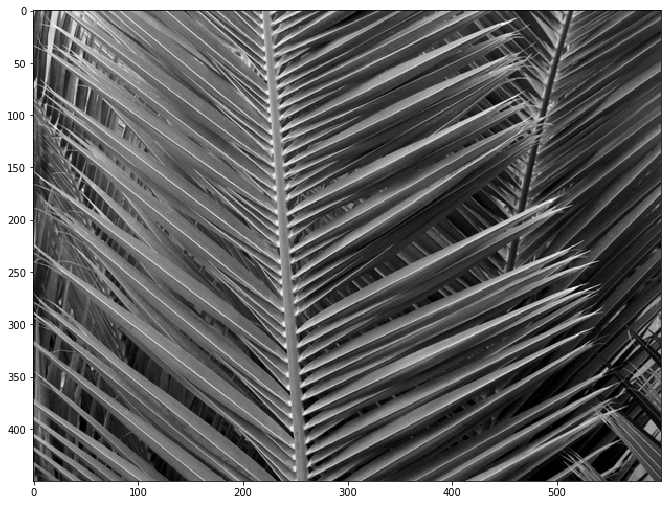

In [6]:
fig = plt.figure(figsize=np.array(pic1.shape)/40)
ax = fig.add_subplot("111")
plt.imshow(pic1,cmap="gray")

## 0. Preprocessing
<br>
Image can be preprocessed using Mean Normalization and Feature Scaling.<br>
Mean Noramlization and Feature scaling is skipped and in place of it, Histogram Equalization is applied to give similar,but better effects.<br>
Image sharpening and noise reduction is not applied as it will be applied later in the algorithm.

In [7]:
## Histogram Equalization
pic1a = cv2.equalizeHist(pic1)
pic2a = cv2.equalizeHist(pic2) 
pic3a = cv2.equalizeHist(pic3)

In [8]:
## CLAHE 
clahe = cv2.createCLAHE()
pic1b = clahe.apply(pic1)
pic2b = clahe.apply(pic2)
pic3b = clahe.apply(pic3)

Text(0.5, 1.0, 'Contrast Limited Adaptive Histogram Equlization with gird(9,9)')

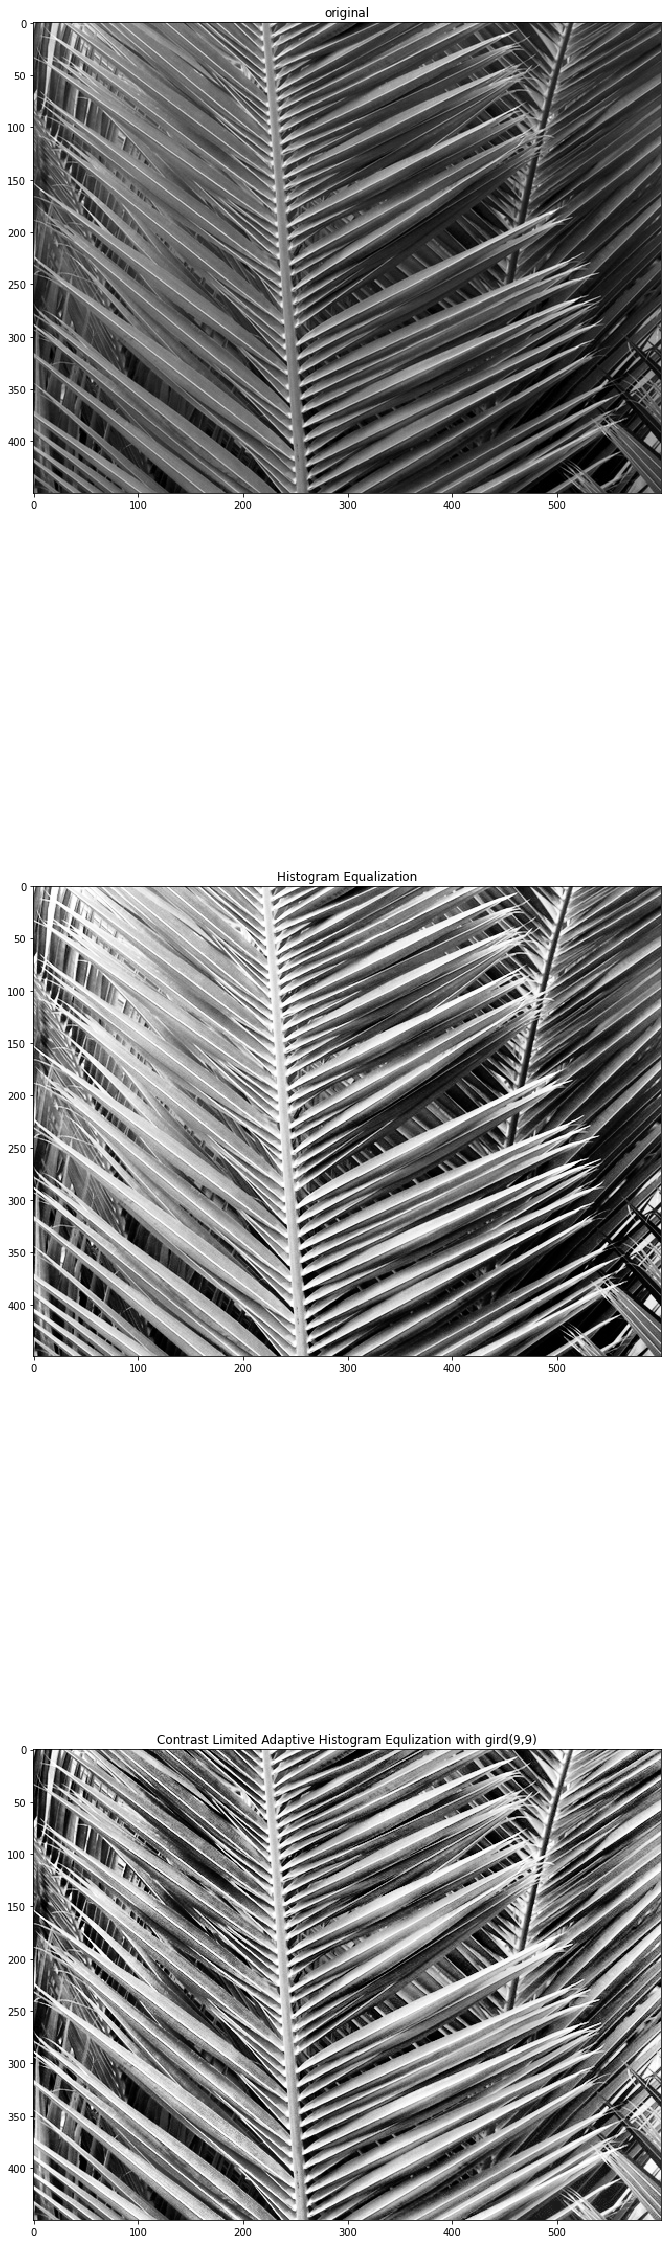

In [103]:
fig = plt.figure(figsize = np.array([pic1.shape[0],pic1.shape[1]*3])/40)
plt.subplot(3,1,1)
plt.imshow(pic1,"gray")
plt.title("original")
plt.subplot(3,1,2)
plt.imshow(pic1a,"gray")
plt.title("Histogram Equalization")
plt.subplot(3,1,3)
plt.imshow(pic1b,"gray")
plt.title("Contrast Limited Adaptive Histogram Equlization with gird(9,9)")

_______________________________________________________________________________________________________________________________

In [96]:
testpic= pic3b

### 1. Getting Gradients          
####               A) Reducing noise with gaussian blur and then taking derivative<br>


In [10]:
def gaussian_filter(px_width):
    sigma = px_width/6
    a = np.zeros((px_width,px_width))
    if px_width%2==1:
        for i in range(px_width):
            for j in range(px_width):
                a[i,j] = (i-px_width//2)**2 + (j-px_width//2)**2
        a = 1/(2 * np.pi * sigma**2) * np.e ** (-1*a/(2*sigma**2))
        a *= 1/a.sum()
        return a

In [11]:
def gradg(pic,px_width=5):
    if px_width%2==1:
        filter = gaussian_filter(px_width)
        tem = convolve2d(pic,filter,mode="same")
        return tem
    else:
        raise Exception("Filter width should be odd")

In [12]:
def gradgd(pic,px_width=5):
    tem = gradg(pic,px_width)
    hx = convolve2d(tem,np.array([[-1.,1.]]),mode= "same") #give partial derivative in horizontal direction/x-direction
    vy = convolve2d(tem,np.array([[1.],[-1.]]),mode="same") #give partial derivative in vertical direction/y-direction
    return hx,vy

Note: cmap is kept 'VIRIDIS' for better visualization


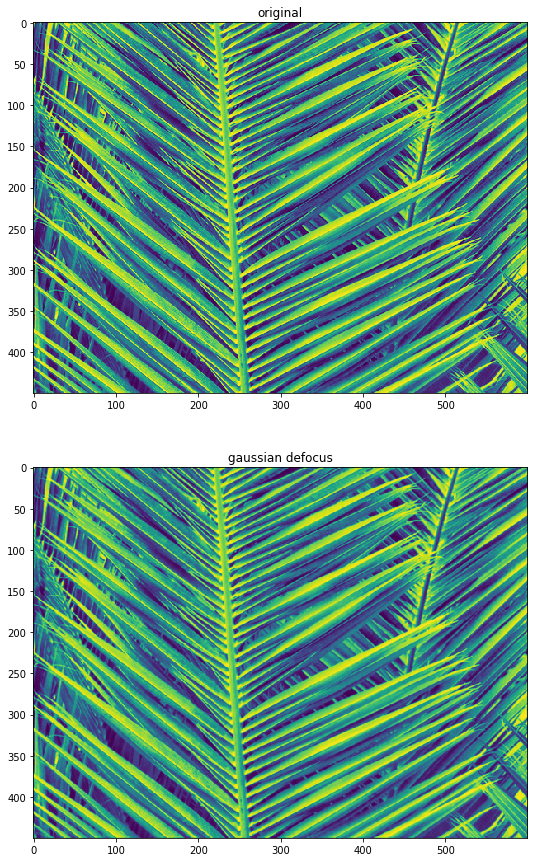

In [97]:
res = gradg(testpic,px_width=3)

#_____________________________________________________________________________________________________________
fig = plt.figure(figsize = np.array((pic1.shape[0]*2,pic1.shape[1]))/40)
ax = fig.add_subplot("211")
ax.imshow(testpic)
plt.title("original")
ax = fig.add_subplot("212")
ax.imshow(res)
plt.title("gaussian defocus")
print("Note: cmap is kept 'VIRIDIS' for better visualization")
#______________________________________________________________________________________________________________

Text(0.5, 1.0, 'vertical gradient')

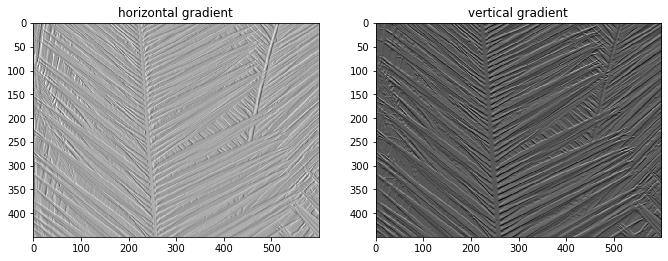

In [99]:
hx,vy = gradgd(testpic,px_width=5)

#____________________________________________________________
fig = plt.figure(figsize =  np.array((temppic.shape[0],temppic.shape[1]*2))/40 )
plt.subplot(1,2,1)
plt.imshow(hx,cmap="gray")
plt.title("horizontal gradient")
plt.subplot(1,2,2)
plt.imshow(vy,cmap="gray")
plt.title("vertical gradient")
#____________________________________________________________

#### B) Convolving using approx. differentiation of gaussian in x and y direction using Sarr filter

In [15]:
def gradsarr(pic):
    sarrx = np.array([[-3,0,3],[-10,0,10],[-3,0,3]])
    sarry = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])
    hx = convolve2d(pic,sarrx,mode="same")
    vy = convolve2d(pic,sarry,mode="same")
    return hx,vy

Text(0.5, 1.0, 'vertical gradient')

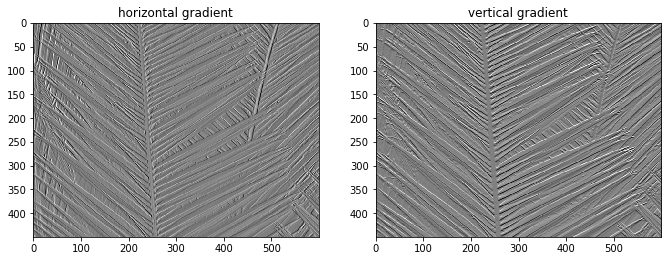

In [16]:
hx,vy = gradsarr(temppic)

#____________________________________________________________
fig = plt.figure(figsize =  np.array((temppic.shape[0],temppic.shape[1]*2))/40 )
plt.subplot(1,2,1)
plt.imshow(hx,cmap="gray")
plt.title("horizontal gradient")
plt.subplot(1,2,2)
plt.imshow(vy,cmap="gray")
plt.title("vertical gradient")
#____________________________________________________________

## 2. Orientation and gradient magnitude calculation

In [17]:
def ogmc(hx,vy):
    mag = (hx**2 + vy**2)**0.5
    angle = np.arctan(vy/(hx+1.0e-8))
    return mag,angle

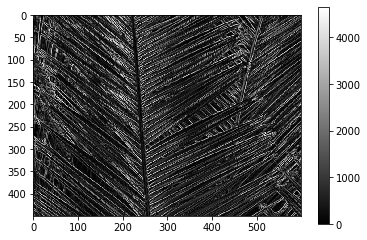

In [18]:
mag,angle=ogmc(hx,vy)

plt.imshow(mag,cmap="gray")
plt.colorbar()

## 3.Non Maximum Suppression
<br>

###  A) Method-1:Considering important 8 directions (E,W,N,S,NE,NW,SE,SW) <br>
         The direction of a given pixel will the direction nearest to the angle of gradient.
         
         For a given pixel being processed,
         
         Case I:  If the 2 neighbouring pixel in the direction of gradient are less intense, then
                  the value of pixel being processed is kept,else
         Case II:  If any of the 2 neighbouring pixel is more intense,then
                   the value of pixel is not kept/made zero
         
         This will reduce the thick ridges to 1 pixel

In [19]:
#Give direction nearest to angle of gradient: {0:E,1:N,0.5:NE,-0.5:SE}
def transform_angle(angle):
    if np.pi/8>angle and -np.pi/8<angle:
        angle=0
    elif np.pi/8>angle and 3*np.pi/8<angle:
        angle=0.5
    elif -3*np.pi/8<angle and -np.pi/8>angle:
        angle=-0.5
    else:
        angle =1
    
    return angle

t_angle = np.vectorize(transform_angle)


In [20]:
#add rows and columns after the transformed angle
def addrc(angle):
    r = np.ones(angle.shape)
    c = np.ones(angle.shape)
    rt = np.arange(1,1+r.shape[0]).reshape((r.shape[0],1))
    r = r * rt
    ct = np.arange(1,1+c.shape[1]).reshape((1,c.shape[1]))
    c = c * ct
    return np.concatenate([angle[:,:,np.newaxis],r[:,:,np.newaxis],c[:,:,np.newaxis]],axis=-1)

In [29]:
def reter(an,tempm):
    
    if an==0:
        if tempm[1,1]>tempm[1,0] and tempm[1,1]>tempm[1,2]:
            return tempm[1,1]
        else:
            return 0
    elif an==1:
        if tempm[1,1]>tempm[0,1] and tempm[1,1]>tempm[2,1]:
            return tempm[1,1]
        else:
            return 0
    elif an==0.5:
        if tempm[1,1]>tempm[2,0] and tempm[1,1]>tempm[0,2]:
            return tempm[1,1]
        else:
            return 0
    else :
        if tempm[1,1]>tempm[0,0] and tempm[1,1]>tempm[2,2]:
            return tempm[1,1]
        else:
            return 0
        
    
def imppx(mag,angle):
    angle = t_angle(angle)
    res = np.zeros(angle.shape)
    
    mag2 = mag.copy()
    mag2 = np.pad(mag2,[[1,1],[1,1]],mode="constant",constant_values = 0)
    for i in range(angle.shape[0]):
        for j in range(angle.shape[1]):
            temp = angle[i,j]
            tempm = mag2[i:i+3,j:j+3]
            res[i,j] = reter(temp,tempm)
            
    return res

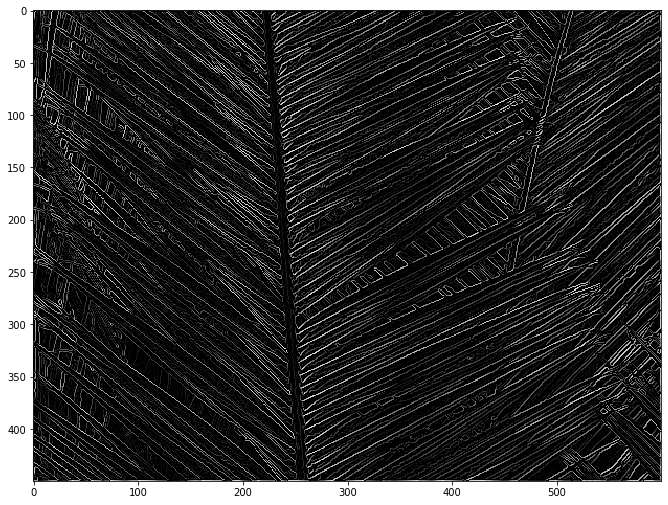

In [106]:
fig = plt.figure(figsize = np.array(mag.shape)/40)
ax = fig.add_subplot("111")
out = imppx(mag,angle)
ax.imshow(out,cmap="gray")

## 4.Double Threshold and Hysteresis

In [52]:
def filt(pic,low=0.3,high=0.7):
    pic = pic/pic.max()
    h = np.where(pic>=high,10,0)
    l = np.where(pic>=low,1,0)
    return h,l

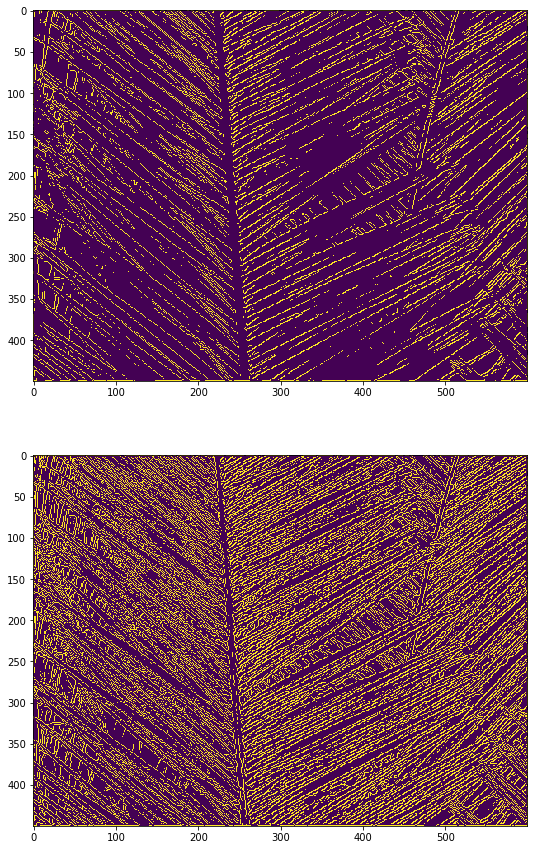

In [105]:
h,l=filt(out,low=0.1,high=0.35)

fig = plt.figure(figsize = np.array([h.shape[0]*2,h.shape[1]])/40)
ax = fig.add_subplot("211")
ax.imshow(h)
ay = fig.add_subplot("212")
ay.imshow(l)

In [88]:
def hysteresis(h,l):
    row,col = h.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            if np.any(h[i-1:i+1,j-1:j+1]) and l[i,j]:
                h[i,j] = 10
    for j in range(1,col-1):
        for i in range(1,row-1):
            if np.any(h[i-1:i+1,j-1:j+1]) and l[i,j]:
                h[i,j] = 10
    for i in range(row-2,0,-1):
        for j in range(col-2,0,-1):
            if np.any(h[i-1:i+1,j-1:j+1]) and l[i,j]:
                h[i,j] = 10
    for j in range(col-2,0,-1):
        for i in range(row-2,0,-1):
            if np.any(h[i-1:i+1,j-1:j+1]) and l[i,j]:
                h[i,j] = 10
    return h

8.828523397445679 secs


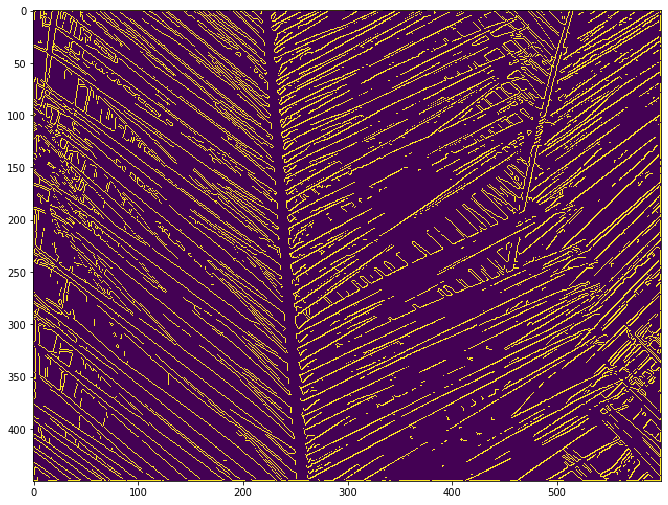

In [104]:
tic = time.time()
h = hysteresis(h,l)
toc = time.time()

print(toc-tic,"secs")

fig = plt.figure(figsize = np.array(h.shape)/40)
plt.imshow(h)

In [74]:
plt.imsave("edge1.jpg",h)

## Final algorithm after preprocessing

45.28024411201477 sec


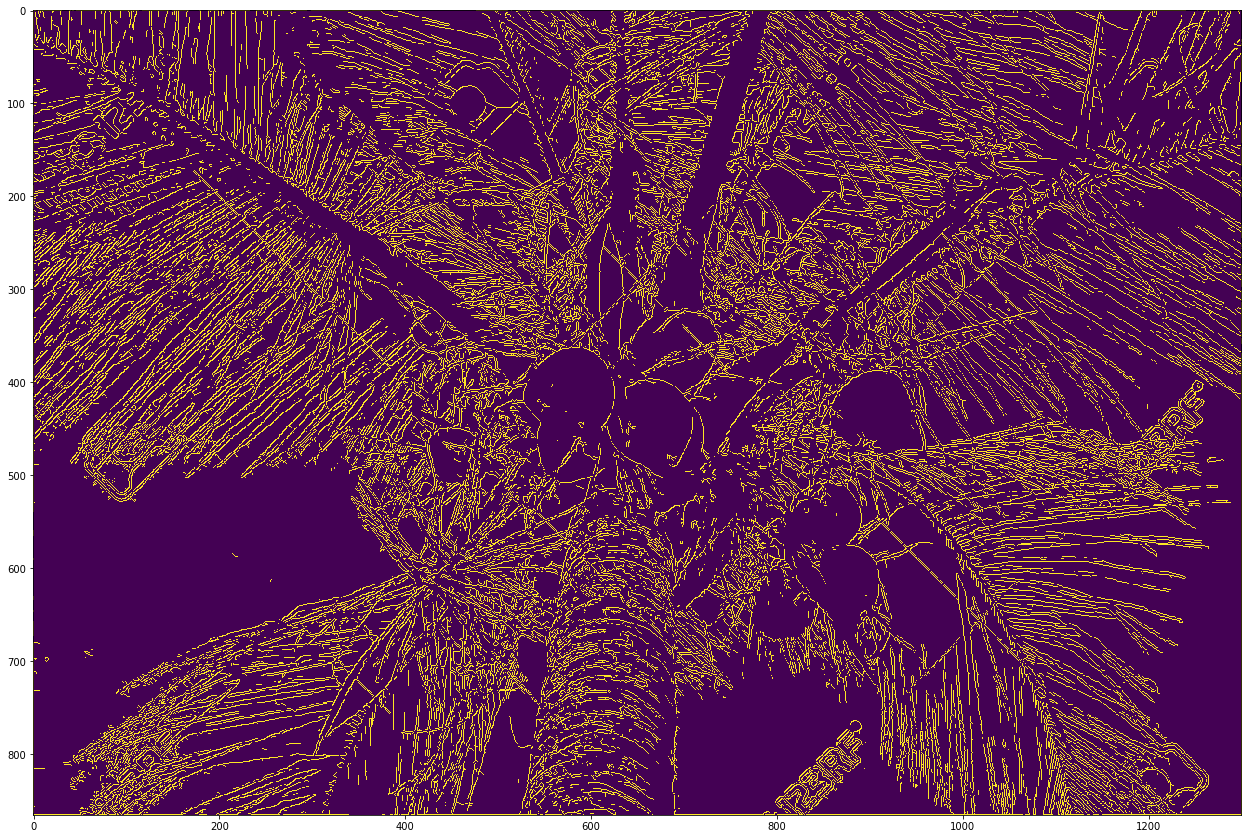

In [118]:
def canny_edge_detector(pic,step1=1,nms=0,high=0.3,low=0.1):
    if step1==0:
        hx,vy = gradgd(pic,px_width=5)
    elif step1==1:
        hx,vy = gradsarr(pic)
    
    mag,angle = ogmc(hx,vy)
    
    if nms==0:
        res = imppx(mag,angle)
        
    h,l = filt(res,low=low,high=high)
    img = hysteresis(h,l)
    return img

tic = time.time()
img = canny_edge_detector(pic2b,step1=1,nms=0)
toc = time.time()

print(toc-tic,"sec")
fig = plt.figure(figsize = np.array(img.shape)/40)
plt.imshow(img)

plt.imsave("edge1.jpg",img)

Due to fine edges,the thresholds (both high and low) are kept at smaller ratio.

This algorithm,since implemented in python, is very slow. However its performance on small images is good but lags at large images.<br>
      
      |       Time        |       Size             |
      | --- | --- |
      |pic1b = 10.69 sec  |no. of pixels = 270000  |
      | --- | --- |
      |pic2b = 44.12 sec  |no. of pixels = 1125800 |
      | --- | --- |
      |pic2c = 47.208 sec |no. of pixels = 1239040 |

For small images, this algorithm can be used as intermediate step or beginning layers in CNN.
